In [1]:
import numpy as np

In [2]:
def extractPoseHand(npy):
    np_matrix=npy.reshape(-1,1629)
    # arr = []
    # print(np_matrix.shape)
    pose  = np_matrix[: ,0:99]
    hands  = np_matrix[: ,1503:1629]
    
 
    arr = np.concatenate((pose, hands), axis=1)


      
    return arr

In [3]:
import random
import os
import numpy as np

crossValidationDataPaths=['RELATIVE_QUANT_D5MAX/Training/RightHand','RELATIVE_QUANT_D5MAX/Training/LeftHand']
testPaths=['RELATIVE_QUANT_D5MAX/Test/RightHand','RELATIVE_QUANT_D5MAX/Test/LeftHand']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    # npy_matrix=npy.reshape(-1,1629)
   
    npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    

test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    # npy_matrix=npy.reshape(-1,1629)

    npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [4]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 64
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,225) # pose hands



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)

2024-01-05 14:31:22.752506: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 14:31:22.773134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 14:31:22.773152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 14:31:22.773698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 14:31:22.777568: I tensorflow/core/platform/cpu_feature_guar

[37, 52, 50, 51, 53, 10, 5, 9, 55, 25, 39, 50, 37, 44, 19, 33, 33, 31, 14, 9, 34, 51, 10, 41, 55, 23, 0, 1, 36, 1, 55, 26, 0, 22, 1, 35, 57, 10, 43, 26, 26, 54, 25, 20, 53, 3, 51, 3, 32, 58, 37, 47, 29, 7, 12, 0, 47, 27, 47, 43, 55, 30, 56, 57, 18, 46, 51, 40, 32, 38, 26, 21, 21, 41, 24, 1, 41, 1, 36, 54, 47, 55, 0, 34, 12, 6, 42, 13, 39, 22, 1, 18, 52, 13, 33, 34, 2, 49, 2, 11, 15, 53, 3, 56, 16, 4, 50, 29, 13, 57, 44, 17, 17, 48, 6, 50, 44, 1, 15, 0, 25, 45, 42, 56, 56, 21, 12, 28, 27, 50, 58, 12, 20, 37, 40, 52, 34, 12, 35, 40, 57, 4, 58, 7, 27, 42, 21, 43, 20, 57, 56, 24, 18, 30, 48, 52, 55, 9, 31, 21, 58, 28, 6, 9, 15, 13, 10, 40, 14, 17, 51, 12, 55, 3, 47, 54, 8, 8, 6, 53, 48, 26, 37, 2, 24, 24, 19, 8, 19, 58, 40, 35, 0, 41, 55, 8, 43, 32, 10, 58, 17, 51, 56, 59, 8, 59, 34, 13, 41, 8, 6, 57, 31, 32, 9, 25, 13, 32, 30, 29, 7, 52, 18, 47, 37, 36, 21, 27, 45, 12, 57, 56, 23, 36, 26, 4, 5, 9, 59, 30, 43, 56, 24, 32, 22, 13, 2, 7, 42, 49, 26, 31, 22, 27, 8, 46, 0, 38, 58, 2, 26, 12, 7

In [5]:


# Define and compile the model


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage],validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


2024-01-05 14:31:24.091143: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-05 14:31:24.091165: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2024-01-05 14:31:24.091168: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2024-01-05 14:31:24.091259: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2024-01-05 14:31:24.091268: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-01-05 14:31:24.091270: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1704443487.536537 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8642 - accuracy: 0.0708

W0000 00:00:1704443494.545175 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 62ms/step - loss: 3.8642 - accuracy: 0.0708 - val_loss: 3.4082 - val_accuracy: 0.1990
Epoch 2/200
113/113 [==============================] - 6s 57ms/step - loss: 3.2399 - accuracy: 0.1923 - val_loss: 2.8622 - val_accuracy: 0.3246
Epoch 3/200
113/113 [==============================] - 7s 58ms/step - loss: 2.8416 - accuracy: 0.2691 - val_loss: 2.4479 - val_accuracy: 0.4714
Epoch 4/200
113/113 [==============================] - 7s 58ms/step - loss: 2.6053 - accuracy: 0.3274 - val_loss: 2.1978 - val_accuracy: 0.5100
Epoch 5/200
113/113 [==============================] - 7s 58ms/step - loss: 2.3719 - accuracy: 0.3755 - val_loss: 1.9765 - val_accuracy: 0.5510
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 2.2012 - accuracy: 0.4180 - val_loss: 1.7932 - val_accuracy: 0.6169
Epoch 7/200
113/113 [==============================] - 7s 58ms/step - loss: 2.0824 - accuracy: 0.4411 - val_loss: 1.6995 - val_accuracy: 0.6294
Epoc

W0000 00:00:1704444492.360274 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 1: 0.9465174129353234
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6982758620689655
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1704444496.913297 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8978 - accuracy: 0.0683

W0000 00:00:1704444504.011320 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 63ms/step - loss: 3.8978 - accuracy: 0.0683 - val_loss: 3.5093 - val_accuracy: 0.1943
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.3170 - accuracy: 0.1851 - val_loss: 2.9060 - val_accuracy: 0.3362
Epoch 3/200
113/113 [==============================] - 7s 61ms/step - loss: 2.8858 - accuracy: 0.2719 - val_loss: 2.5314 - val_accuracy: 0.4321
Epoch 4/200
113/113 [==============================] - 7s 58ms/step - loss: 2.5976 - accuracy: 0.3347 - val_loss: 2.1945 - val_accuracy: 0.5168
Epoch 5/200
113/113 [==============================] - 7s 58ms/step - loss: 2.3328 - accuracy: 0.4008 - val_loss: 1.9300 - val_accuracy: 0.5903
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.1443 - accuracy: 0.4451 - val_loss: 1.7868 - val_accuracy: 0.6177
Epoch 7/200
113/113 [==============================] - 7s 58ms/step - loss: 2.0284 - accuracy: 0.4667 - val_loss: 1.5781 - val_accuracy: 0.6936
Epoc

W0000 00:00:1704444915.848049 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 2: 0.9327521793275217
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.7178683385579937
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1704444920.162082 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8682 - accuracy: 0.0814

W0000 00:00:1704444927.337695 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 64ms/step - loss: 3.8682 - accuracy: 0.0814 - val_loss: 3.5059 - val_accuracy: 0.2267
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.3408 - accuracy: 0.1893 - val_loss: 2.9612 - val_accuracy: 0.3176
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.9815 - accuracy: 0.2768 - val_loss: 2.6512 - val_accuracy: 0.4334
Epoch 4/200
113/113 [==============================] - 7s 62ms/step - loss: 2.7198 - accuracy: 0.3269 - val_loss: 2.3800 - val_accuracy: 0.4732
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.5110 - accuracy: 0.3615 - val_loss: 2.1199 - val_accuracy: 0.5430
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.3290 - accuracy: 0.3967 - val_loss: 1.9545 - val_accuracy: 0.5679
Epoch 7/200
113/113 [==============================] - 7s 58ms/step - loss: 2.1794 - accuracy: 0.4365 - val_loss: 1.7773 - val_accuracy: 0.6513
Epo

W0000 00:00:1704445648.761295 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 3: 0.9414694894146949
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.7115987460815048
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1704445653.206036 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9082 - accuracy: 0.0653

W0000 00:00:1704445660.334431 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 64ms/step - loss: 3.9082 - accuracy: 0.0653 - val_loss: 3.5924 - val_accuracy: 0.1806
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.3693 - accuracy: 0.1709 - val_loss: 3.0545 - val_accuracy: 0.2802
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.9544 - accuracy: 0.2641 - val_loss: 2.6262 - val_accuracy: 0.3786
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.6579 - accuracy: 0.3165 - val_loss: 2.3455 - val_accuracy: 0.4545
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4205 - accuracy: 0.3827 - val_loss: 2.1301 - val_accuracy: 0.5230
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.2609 - accuracy: 0.4144 - val_loss: 1.9300 - val_accuracy: 0.5616
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 2.0933 - accuracy: 0.4553 - val_loss: 1.7163 - val_accuracy: 0.6152
Epo

W0000 00:00:1704446390.653439 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 4: 0.9601494396014943
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.707680250783699
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1704446394.837453 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9342 - accuracy: 0.0641

W0000 00:00:1704446401.934887 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 63ms/step - loss: 3.9342 - accuracy: 0.0641 - val_loss: 3.6274 - val_accuracy: 0.1270
Epoch 2/200
113/113 [==============================] - 7s 58ms/step - loss: 3.4637 - accuracy: 0.1555 - val_loss: 3.1918 - val_accuracy: 0.3213
Epoch 3/200
113/113 [==============================] - 7s 58ms/step - loss: 3.1530 - accuracy: 0.2169 - val_loss: 2.8692 - val_accuracy: 0.3848
Epoch 4/200
113/113 [==============================] - 7s 58ms/step - loss: 2.8966 - accuracy: 0.2742 - val_loss: 2.6092 - val_accuracy: 0.4396
Epoch 5/200
113/113 [==============================] - 7s 58ms/step - loss: 2.7061 - accuracy: 0.3196 - val_loss: 2.4073 - val_accuracy: 0.4682
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 2.5615 - accuracy: 0.3480 - val_loss: 2.2026 - val_accuracy: 0.5293
Epoch 7/200
113/113 [==============================] - 7s 58ms/step - loss: 2.4122 - accuracy: 0.3853 - val_loss: 2.0642 - val_accuracy: 0.5691
Epoc

W0000 00:00:1704446945.481579 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 5: 0.925280199252802
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6912225705329154
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1704446949.949675 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9347 - accuracy: 0.0625

W0000 00:00:1704446957.091375 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.9347 - accuracy: 0.0625 - val_loss: 3.6680 - val_accuracy: 0.1146
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.4342 - accuracy: 0.1610 - val_loss: 3.1380 - val_accuracy: 0.2665
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 3.0607 - accuracy: 0.2374 - val_loss: 2.7521 - val_accuracy: 0.3574
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.7562 - accuracy: 0.3088 - val_loss: 2.4515 - val_accuracy: 0.4110
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.5127 - accuracy: 0.3597 - val_loss: 2.1964 - val_accuracy: 0.4944
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.3489 - accuracy: 0.3942 - val_loss: 1.9890 - val_accuracy: 0.5380
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 2.1669 - accuracy: 0.4355 - val_loss: 1.8272 - val_accuracy: 0.5654
Epoc

W0000 00:00:1704447745.034688 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 6: 0.9389788293897883
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6959247648902821
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1704447749.195096 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9535 - accuracy: 0.0520

W0000 00:00:1704447756.624763 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 66ms/step - loss: 3.9535 - accuracy: 0.0520 - val_loss: 3.6372 - val_accuracy: 0.1233
Epoch 2/200
113/113 [==============================] - 7s 60ms/step - loss: 3.4479 - accuracy: 0.1581 - val_loss: 3.1699 - val_accuracy: 0.2740
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 3.0969 - accuracy: 0.2357 - val_loss: 2.7963 - val_accuracy: 0.3674
Epoch 4/200
113/113 [==============================] - 7s 58ms/step - loss: 2.8438 - accuracy: 0.2862 - val_loss: 2.5774 - val_accuracy: 0.4172
Epoch 5/200
113/113 [==============================] - 7s 58ms/step - loss: 2.6303 - accuracy: 0.3312 - val_loss: 2.3205 - val_accuracy: 0.4334
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.4557 - accuracy: 0.3733 - val_loss: 2.1606 - val_accuracy: 0.4944
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 2.3140 - accuracy: 0.4012 - val_loss: 2.0025 - val_accuracy: 0.5492
Epo

W0000 00:00:1704448535.907268 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 7: 0.9439601494396015
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.7249216300940439
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1704448540.178771 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9117 - accuracy: 0.0667

W0000 00:00:1704448547.411686 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 65ms/step - loss: 3.9117 - accuracy: 0.0667 - val_loss: 3.6145 - val_accuracy: 0.1445
Epoch 2/200
113/113 [==============================] - 7s 60ms/step - loss: 3.3946 - accuracy: 0.1713 - val_loss: 3.0568 - val_accuracy: 0.2727
Epoch 3/200
113/113 [==============================] - 7s 64ms/step - loss: 2.9854 - accuracy: 0.2522 - val_loss: 2.6942 - val_accuracy: 0.3400
Epoch 4/200
113/113 [==============================] - 10s 92ms/step - loss: 2.6929 - accuracy: 0.3206 - val_loss: 2.4005 - val_accuracy: 0.4346
Epoch 5/200
113/113 [==============================] - 17s 153ms/step - loss: 2.5089 - accuracy: 0.3628 - val_loss: 2.1658 - val_accuracy: 0.4956
Epoch 6/200
113/113 [==============================] - 18s 161ms/step - loss: 2.3137 - accuracy: 0.4016 - val_loss: 2.0190 - val_accuracy: 0.5218
Epoch 7/200
113/113 [==============================] - 18s 155ms/step - loss: 2.1865 - accuracy: 0.4245 - val_loss: 1.8659 - val_accuracy: 0.56

W0000 00:00:1704450179.843913 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 38ms/step
Validation Accuracy Fold 8: 0.9389788293897883
40/40 [==============================] - 2s 40ms/step
Test - Accuracy: 0.7210031347962382
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1704450195.131709 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9439 - accuracy: 0.0537

W0000 00:00:1704450216.553344 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 30s 190ms/step - loss: 3.9439 - accuracy: 0.0537 - val_loss: 3.6512 - val_accuracy: 0.1283
Epoch 2/200
113/113 [==============================] - 18s 155ms/step - loss: 3.4668 - accuracy: 0.1601 - val_loss: 3.1731 - val_accuracy: 0.2217
Epoch 3/200
113/113 [==============================] - 18s 155ms/step - loss: 3.1278 - accuracy: 0.2223 - val_loss: 2.8309 - val_accuracy: 0.3238
Epoch 4/200
113/113 [==============================] - 18s 157ms/step - loss: 2.8631 - accuracy: 0.2793 - val_loss: 2.5866 - val_accuracy: 0.4047
Epoch 5/200
113/113 [==============================] - 18s 158ms/step - loss: 2.6657 - accuracy: 0.3204 - val_loss: 2.3399 - val_accuracy: 0.4869
Epoch 6/200
113/113 [==============================] - 17s 155ms/step - loss: 2.4645 - accuracy: 0.3662 - val_loss: 2.1382 - val_accuracy: 0.5156
Epoch 7/200
113/113 [==============================] - 17s 146ms/step - loss: 2.3260 - accuracy: 0.3917 - val_loss: 1.9896 - val_accurac

W0000 00:00:1704451058.723291 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 24ms/step
Validation Accuracy Fold 9: 0.9202988792029888
40/40 [==============================] - 1s 24ms/step
Test - Accuracy: 0.695141065830721
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1704451066.946274 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 4.0025 - accuracy: 0.0465

W0000 00:00:1704451079.421526 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 17s 111ms/step - loss: 4.0025 - accuracy: 0.0465 - val_loss: 3.7441 - val_accuracy: 0.1220
Epoch 2/200
113/113 [==============================] - 11s 101ms/step - loss: 3.5735 - accuracy: 0.1346 - val_loss: 3.2329 - val_accuracy: 0.2516
Epoch 3/200
113/113 [==============================] - 11s 101ms/step - loss: 3.2034 - accuracy: 0.2118 - val_loss: 2.9023 - val_accuracy: 0.3250
Epoch 4/200
113/113 [==============================] - 11s 101ms/step - loss: 2.9539 - accuracy: 0.2690 - val_loss: 2.6369 - val_accuracy: 0.4035
Epoch 5/200
113/113 [==============================] - 12s 102ms/step - loss: 2.7339 - accuracy: 0.3116 - val_loss: 2.3797 - val_accuracy: 0.4819
Epoch 6/200
113/113 [==============================] - 11s 101ms/step - loss: 2.5376 - accuracy: 0.3502 - val_loss: 2.1898 - val_accuracy: 0.5181
Epoch 7/200
113/113 [==============================] - 10s 85ms/step - loss: 2.3879 - accuracy: 0.3875 - val_loss: 2.0104 - val_accuracy

W0000 00:00:1704452234.979072 1015360 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 10: 0.9514321295143213
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6912225705329154
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [6]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.6982758620689655, 0.7178683385579937, 0.7115987460815048, 0.707680250783699, 0.6912225705329154, 0.6959247648902821, 0.7249216300940439, 0.7210031347962382, 0.695141065830721, 0.6912225705329154]
0.7054858934169278
[0.9465174129353234, 0.9327521793275217, 0.9414694894146949, 0.9601494396014943, 0.925280199252802, 0.9389788293897883, 0.9439601494396015, 0.9389788293897883, 0.9202988792029888, 0.9514321295143213]
0.9399817537468325


test accuracies:  [0.6982758620689655, 0.7178683385579937, 0.7115987460815048, 0.707680250783699, 0.6912225705329154, 0.6959247648902821, 0.7249216300940439, 0.7210031347962382, 0.695141065830721, 0.6912225705329154] 6
validation accuracies:  [0.9465174129353234, 0.9327521793275217, 0.9414694894146949, 0.9601494396014943, 0.925280199252802, 0.9389788293897883, 0.9439601494396015, 0.9389788293897883, 0.9202988792029888, 0.9514321295143213]
60


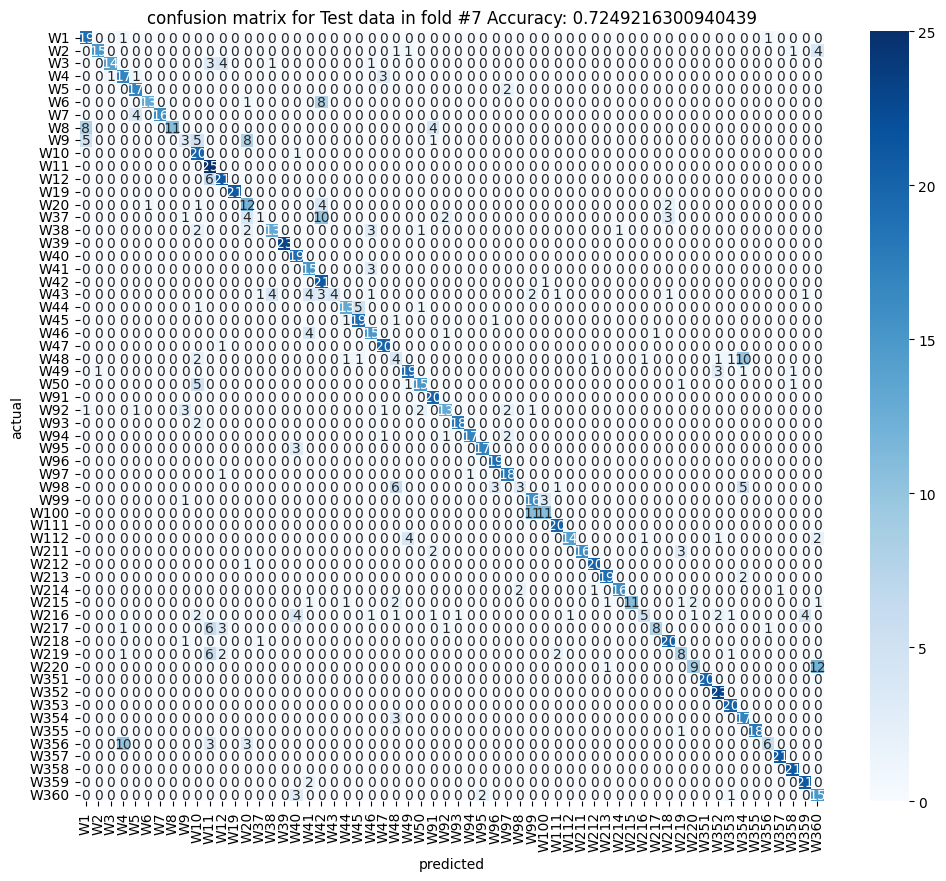

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()
